# Зависимости

In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

# Лабораторная работа №2

In [2]:
#подключаем гугл-диск для загрузки датасета
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/MyDrive/Example6/mitbih_train.csv'
file_path_test = '/content/drive/MyDrive/Example6/mitbih_test.csv'

Mounted at /content/drive


In [3]:
#датасет большой, поэтому сформируем случайным образом тренировочный датасет
import random

n = 80000 #number of records in file
s = 50000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

df_mitbih_train = pd.read_csv(file_path_train, header=None, skiprows=skip)
df_mitbih_test = pd.read_csv(file_path_test, header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [4]:
# датасет размечен на 5 классов
# в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [5]:
# добавим текстовое описание к размеченным классам
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 71238 entries, 0 to 13683
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 103.3+ MB
None


In [6]:
#классы несбалансированы
df_mitbih_train['class'].value_counts()

,count
class,
0.0,45281
4.0,6431
2.0,3804
1.0,1397
3.0,641


In [7]:
#создаем процедуру перемешивания данных и их балансировки
from sklearn.utils import shuffle
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Создание экземпляра RandomUnderSampler
rus_method = RandomUnderSampler()

df = df_mitbih_train

# Применение уменьшения выборки к данным
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df, df['class'])

new_df =pd.concat([X_resampled, y_resampled])

#не забываем удалить NaN
new_df = new_df.dropna()
new_df['class'].value_counts()
#получаем взвешенную выборку

,count
class,
0.0,641
1.0,641
2.0,641
3.0,641
4.0,641


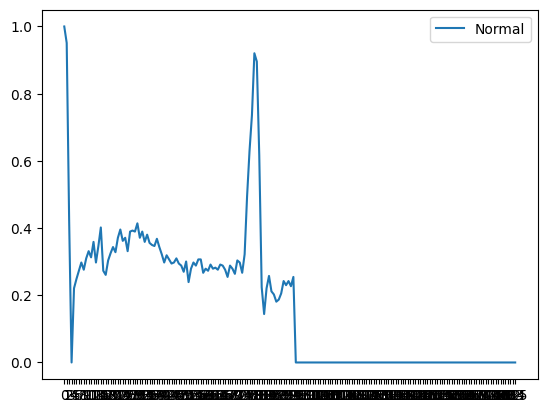

In [9]:
# пример как выглядит кардиограмма из датасета
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

In [10]:
#проверяем, что нет больше значений NaN
check_nan = new_df.isnull().values.any()
print(check_nan)

False


In [11]:
df_mitbih_train = new_df

# Лабораторная работа №3 - Обучение моделей

## Обучение LSTM с механизмом внимания в PyTorch

### Модель

Epoch 1/500: Train Loss = 1.5792, Train Acc = 0.2271 | Val Loss = 1.5638, Val Acc = 0.0776
Epoch 2/500: Train Loss = 1.4675, Train Acc = 0.3039 | Val Loss = 1.4643, Val Acc = 0.0459
Epoch 3/500: Train Loss = 1.3752, Train Acc = 0.3953 | Val Loss = 1.3894, Val Acc = 0.3123
Epoch 4/500: Train Loss = 1.3513, Train Acc = 0.4153 | Val Loss = 1.4087, Val Acc = 0.1411
Epoch 5/500: Train Loss = 1.2513, Train Acc = 0.4836 | Val Loss = 1.4050, Val Acc = 0.3309
Epoch 6/500: Train Loss = 1.3827, Train Acc = 0.3931 | Val Loss = 1.6541, Val Acc = 0.1124
Epoch 7/500: Train Loss = 1.4077, Train Acc = 0.3672 | Val Loss = 1.3850, Val Acc = 0.0694
Epoch 8/500: Train Loss = 1.3117, Train Acc = 0.4396 | Val Loss = 1.3282, Val Acc = 0.1638
Epoch 9/500: Train Loss = 1.1767, Train Acc = 0.5080 | Val Loss = 1.0630, Val Acc = 0.4974
Epoch 10/500: Train Loss = 1.1657, Train Acc = 0.5129 | Val Loss = 1.3203, Val Acc = 0.1203
Epoch 11/500: Train Loss = 1.0918, Train Acc = 0.5491 | Val Loss = 1.2098, Val Acc = 0.28

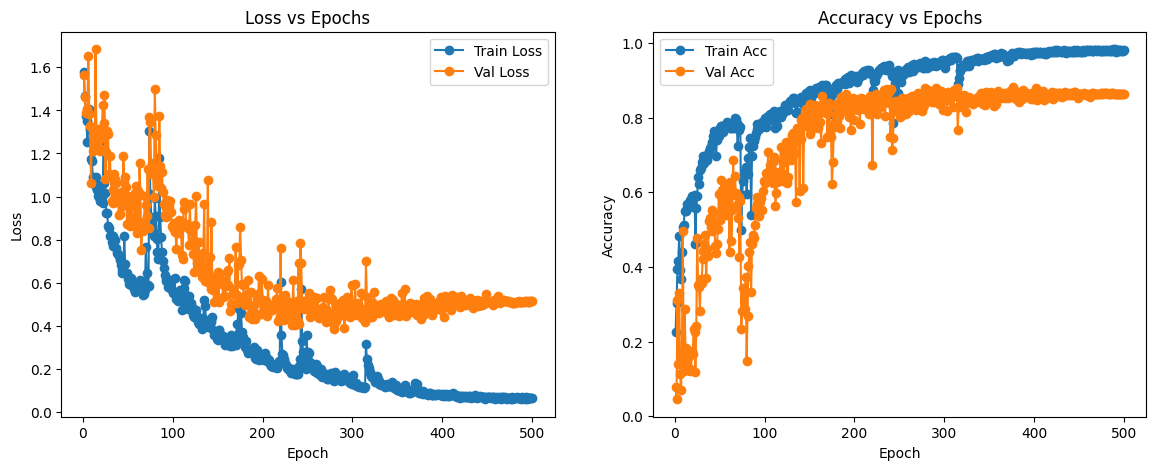

Confusion Matrix:
[[9685  921  220  412  100]
 [  44  282    8    9    2]
 [  31   11  787   55    3]
 [   0    2    4  100    0]
 [  14    7   11    5  971]]
Test Accuracy: 0.8641
Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.8542    0.9175     11338
           1     0.2306    0.8174    0.3597       345
           2     0.7641    0.8873    0.8211       887
           3     0.1721    0.9434    0.2911       106
           4     0.9024    0.9633    0.9319      1008

    accuracy                         0.8641     13684
   macro avg     0.6120    0.8931    0.6642     13684
weighted avg     0.9442    0.8641    0.8934     13684



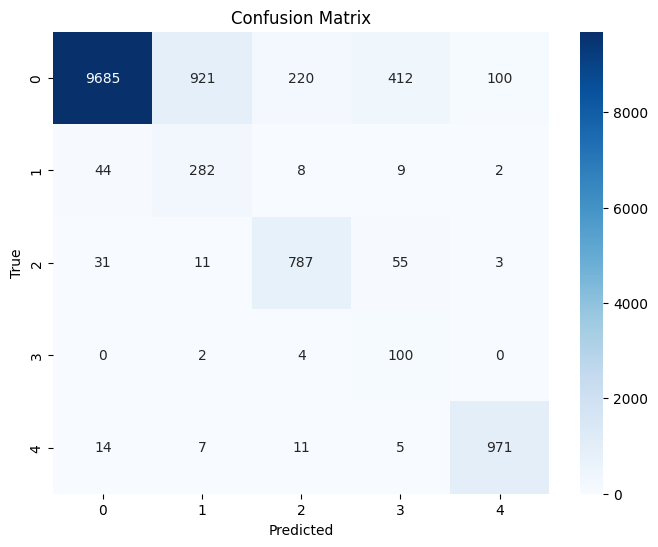

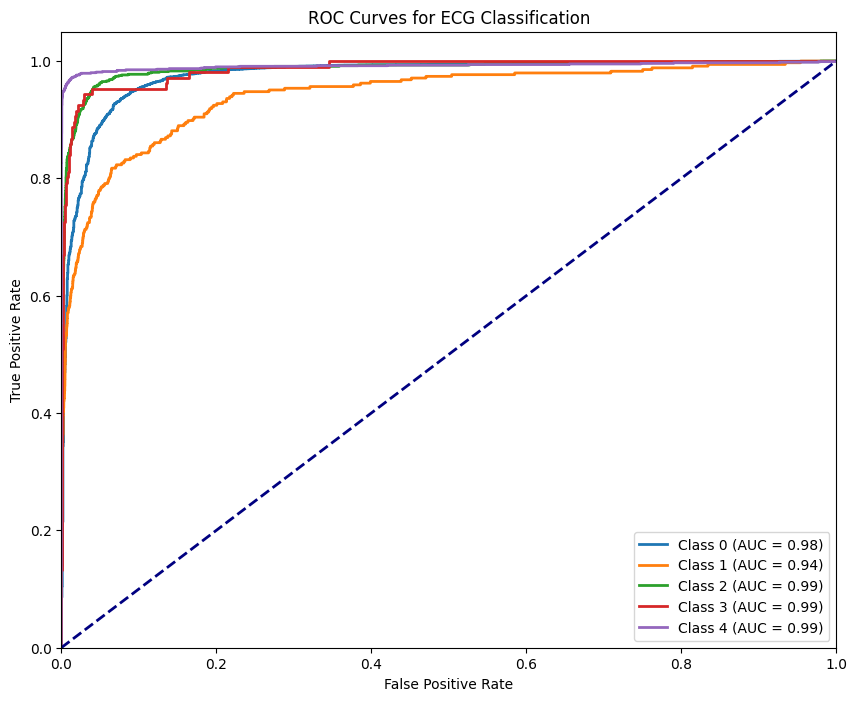

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc


# Функция для преобразования DataFrame в датасет
class ECGDataset(Dataset):
    def __init__(self, features_df, labels_series):
        self.X = features_df.values.astype(np.float32)  # (N, 187)
        self.y = labels_series.values.astype(np.int64)    # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        sample = self.X[idx].reshape(-1, 1)  # преобразуем (187,) в (187, 1)
        label = self.y[idx]
        return sample, label

# Подготовка данных
X_train = pd.DataFrame(df_mitbih_train.iloc[:, :187].values,
                       columns=[str(i) for i in range(187)]).reset_index(drop=True)
X_val = pd.DataFrame(df_mitbih_test.iloc[:, :187].values,
                     columns=[str(i) for i in range(187)]).reset_index(drop=True)

# Извлекаем целевую переменную
y_train = pd.Series(df_mitbih_train.iloc[:, 187].values).astype(int).reset_index(drop=True)
y_val = pd.Series(df_mitbih_test.iloc[:, 187].values).astype(int).reset_index(drop=True)

# Создаем датасеты и DataLoader'ы
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Модель LSTM с механизмом внимания
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)  # Преобразует скрытое состояние в скалярную оценку
    def forward(self, lstm_outputs):
        # lstm_outputs: (batch, seq_len, hidden_dim)
        scores = self.attention(lstm_outputs)                # (batch, seq_len, 1)
        attn_weights = torch.softmax(scores, dim=1)           # (batch, seq_len, 1)
        context = torch.sum(attn_weights * lstm_outputs, dim=1) # (batch, hidden_dim)
        return context, attn_weights

class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, num_classes=5, dropout=0.5):
        super(LSTMAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=False)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # x: (batch, seq_len, input_dim) -> (batch, 187, 1)
        lstm_out, _ = self.lstm(x)                         # (batch, 187, hidden_dim)
        context, attn_weights = self.attention(lstm_out)     # (batch, hidden_dim)
        logits = self.fc(context)                          # (batch, num_classes)
        return logits, attn_weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMAttentionClassifier(input_dim=1, hidden_dim=64, num_layers=3, num_classes=5, dropout=0.4)
model.to(device)

# Обучение
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 500
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)   # (batch, 187, 1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)     # outputs: (batch, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_correct / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    epoch_val_loss = val_loss / total_val
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss = {epoch_train_loss:.4f}, Train Acc = {epoch_train_acc:.4f} | "
          f"Val Loss = {epoch_val_loss:.4f}, Val Acc = {epoch_val_acc:.4f}")

# Графики обучения
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# Оценка на тестовом наборе, построение confusion matrix, ROC-кривых и classification report
model.eval()
all_preds = []
all_true = []
all_probs = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs, _ = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
acc = accuracy_score(all_true, all_preds)
report = classification_report(all_true, all_preds, digits=4)

print("Confusion Matrix:")
print(cm)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(report)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-кривые для мультклассовой классификации:
# Для ROC нужно бинараизовать метки.
from sklearn.preprocessing import label_binarize
n_classes = 5
all_true_np = np.array(all_true)
all_probs_np = np.array(all_probs)  # shape: (n_samples, 5)
all_true_bin = label_binarize(all_true_np, classes=range(n_classes))

plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ECG Classification')
plt.legend(loc="lower right")
plt.show()


In [14]:
torch.save(model,"ex6.pth")

## FEDOT

In [ ]:
!pip install -U fedot

In [ ]:
from fedot.api.main import Fedot
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef)
import numpy as np
import numpy as np



# Извлекаем признаки и метки из DataFrame
X_train = df_mitbih_train.iloc[:, :187].values
y_train = df_mitbih_train['label'].values
X_test = df_mitbih_test.iloc[:, :187].values
y_test = df_mitbih_test['label'].values

# Задаём тип задачи: мультклассовая классификация
automl_fedot = Fedot(problem='classification', timeout=15, cv_folds=5, n_jobs=4)
automl_fedot.fit(features=X_train, target=y_train)
preds_fedot = automl_fedot.predict(features=X_test)

preds_fedot = np.array(preds_fedot.data)

# Оценим результат
cm_fedot = confusion_matrix(y_test, preds_fedot)
acc_fedot = accuracy_score(y_test, preds_fedot)
precision_fedot = precision_score(y_test, preds_fedot, average='macro')
recall_fedot = recall_score(y_test, preds_fedot, average='macro')
f1_fedot = f1_score(y_test, preds_fedot, average='macro')
report_fedot = classification_report(y_test, preds_fedot, digits=4)
print("Confusion Matrix:\n", cm_fedot)
print("Accuracy: {:.4f}".format(acc_fedot))
print("Precision (macro): {:.4f}".format(precision_fedot))
print("Recall (macro): {:.4f}".format(recall_fedot))
print("F1 Score (macro): {:.4f}".format(f1_fedot))
print("Classification Report:\n", report_fedot)

Level 45:root:ApiComposer - Initial pipeline was fitted in 52.6 sec.


2025-04-09 09:41:21,453 - ApiComposer - Initial pipeline was fitted in 52.6 sec.


Level 45:root:ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 263.1 sec.


2025-04-09 09:41:21,460 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 263.1 sec.


Level 45:root:AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


2025-04-09 09:41:21,464 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


Level 45:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 15 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


2025-04-09 09:41:21,482 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 15 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


Level 45:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 263.12556 sec.


2025-04-09 09:41:21,713 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 263.12556 sec.


Level 45:root:ApiComposer - Hyperparameters tuning started with 14 min. timeout


2025-04-09 09:41:21,814 - ApiComposer - Hyperparameters tuning started with 14 min. timeout


Level 45:root:SimultaneousTuner - Initial graph: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 

2025-04-09 09:45:42,123 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30

Level 45:root:SimultaneousTuner - Final graph: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 2,

2025-04-09 09:55:36,247 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 

Level 45:root:SimultaneousTuner - Final metric: 0.979


2025-04-09 09:55:36,253 - SimultaneousTuner - Final metric: 0.979


Level 45:root:ApiComposer - Hyperparameters tuning finished


2025-04-09 09:55:36,267 - ApiComposer - Hyperparameters tuning finished


Level 45:root:ApiComposer - Model generation finished


2025-04-09 09:55:36,736 - ApiComposer - Model generation finished


Level 45:root:FEDOT logger - Final pipeline was fitted


2025-04-09 09:56:31,401 - FEDOT logger - Final pipeline was fitted


Level 45:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 2, '

2025-04-09 09:56:31,408 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n

## LAMA

In [ ]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00

In [ ]:
import pandas as pd
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef
)

# Создаем DataFrame для признаков с именами столбцов-строк.
X_train = pd.DataFrame(df_mitbih_train.iloc[:, :187].values,
                       columns=[str(i) for i in range(187)]).reset_index(drop=True)
X_test  = pd.DataFrame(df_mitbih_test.iloc[:, :187].values,
                       columns=[str(i) for i in range(187)]).reset_index(drop=True)

# Извлекаем целевую переменную
y_train = pd.Series(df_mitbih_train.iloc[:, 187].values).astype(int).reset_index(drop=True)
y_test  = pd.Series(df_mitbih_test.iloc[:, 187].values).astype(int).reset_index(drop=True)
# Задаем имя для Series target – это важно для ролей.
y_train.name = 'target'
y_test.name  = 'target'

# Объединяем признаки и target в один DataFrame для обучения.
df_train = X_train.copy()
df_train['target'] = y_train

df_test = X_test.copy()

# Определяем задачу – мультклассовая классификация
task = Task('multiclass')

# Создаем объект LightAutoML
automl_lama = TabularAutoML(task=task, timeout=15, cpu_limit=4)

# Обучаем модель
oof_preds = automl_lama.fit_predict(df_train, roles={'target': 'target'}).data

# Выполняем предсказание для тестовых данных.
test_preds_obj = automl_lama.predict(df_test)
# Преобразуем вероятностные предсказания в финальные классы.
test_preds = np.argmax(test_preds_obj.data, axis=1)

# Метрики
cm = confusion_matrix(y_test, test_preds)
acc = accuracy_score(y_test, test_preds)
precision_macro = precision_score(y_test, test_preds, average='macro')
recall_macro = recall_score(y_test, test_preds, average='macro')
f1_macro = f1_score(y_test, test_preds, average='macro')
report = classification_report(y_test, test_preds, digits=4)

print("Confusion Matrix:\n", cm)
print("Accuracy: {:.4f}".format(acc))
print("Precision (macro): {:.4f}".format(precision_macro))
print("Recall (macro): {:.4f}".format(recall_macro))
print("F1 Score (macro): {:.4f}".format(f1_macro))
print("Classification Report:\n", report)

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: multiclass

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 15.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (3205, 188)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 11.50 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'embed_sizes': array([11, 11, 11, 11,

Confusion Matrix:
 [[9510  748  473  482  120]
 [  45  273    5    4    2]
 [  30   10  795   50    7]
 [   5    0    4   98    0]
 [  16    6   11    4  967]]
Accuracy: 0.8520
Precision (macro): 0.5813
Recall (macro): 0.8878
F1 Score (macro): 0.6443
Classification Report:
               precision    recall  f1-score   support

           0     0.9900    0.8391    0.9084     11333
           1     0.2633    0.8298    0.3997       329
           2     0.6172    0.8913    0.7294       892
           3     0.1536    0.9159    0.2631       107
           4     0.8823    0.9631    0.9210      1004

    accuracy                         0.8520     13665
   macro avg     0.5813    0.8878    0.6443     13665
weighted avg     0.9337    0.8520    0.8803     13665

